# Data Load and preparing the environment
start with running setup.sh

Now we need to install the modules that we need for this notebook if they were not installed in setup.sh

In [2]:
# !pip uninstall httpx -y
# !pip install httpx=='0.27.2'
# !pip install openai
# !pip install langchain-openai
# !pip install python-dotenv
# !pip install langdetect
# !pip install tiktoken

Found existing installation: httpx 0.28.0
Uninstalling httpx-0.28.0:
  Successfully uninstalled httpx-0.28.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00


Loading the environment variables into notebook with dotenv. The .env should also have OPENAI_API_KEY for using llms.

# DOUBLE CHECK .GITIGNORE

In [3]:
from dotenv import load_dotenv
load_dotenv('projects/ConvFinQA_llm/.env')

True

# Data exploration

### Basic

In [51]:
import os
import json
import pandas as pd
import chromadb
import openai
from langdetect import detect
import matplotlib.pyplot as plt
from copy import deepcopy
import tiktoken
from time import sleep
import re

In [5]:
def load_json(json_path):
  """

  Args:
    json_path: string path to file to load
  """
  with open(json_path, 'r') as file:
    data = json.load(file)
  return(data)


In [6]:
data_path = 'projects/ConvFinQA_llm/data/train.json'

In [7]:
train = load_json(data_path)

In [8]:
len(train)

3037

In [9]:
train[0].keys()

dict_keys(['pre_text', 'post_text', 'filename', 'table_ori', 'table', 'qa', 'id', 'annotation'])

In [10]:
# let's check if each question is based on its own file:

pd.Series([el['filename'] for el in train]).value_counts()[:10]

,count
RE/2010/page_138.pdf,7
UPS/2012/page_51.pdf,5
ETR/2008/page_313.pdf,5
AAL/2015/page_51.pdf,5
CAT/2017/page_103.pdf,5
AMT/2005/page_84.pdf,5
UPS/2014/page_35.pdf,5
AMAT/2014/page_37.pdf,5
CE/2011/page_17.pdf,5
ETR/2008/page_356.pdf,5


Some documents appear in more than one question. There might be different pieces from the same large underlying file.

Based on that I would avoid creating any indexing solutions based on the file name alone. We need to use file name in combination with a numeric index to create a truly unique index.

In [11]:
!pip install tiktoken

In [12]:
# joining pre_text into one text

for record in train:
  record['pre_text_string'] = ' '.join(record['pre_text'])
  record['post_text_string'] = ' '.join(record['post_text'])

In [13]:
# checking languages used in the texts - that might take some time
# first 1000 symbols is a rule of thumb but it is generally enough for the modern language detection models
pd.Series([detect(el['pre_text_string'] + record['post_text_string'][:1000]) for el in train]).value_counts()

,count
en,3037


The dataset features only English documents

* removes multilingual support requirement from POC

* widens the list of available LLMs - some of the commercially available models are mostly trained on the corpuses from Anglosphere and can show lowered performance in a task formulated in one of Asian languages for example.

### Table data analysis and processing

It is clear that answer is frequently derived from tables, and additional calculation and reasoning are often needed to extract an answer.

Since qa dict included *gold_inds* field, we can see that the original researcher have done some kind of table parsing to post-process the tables as strings of connected statements.

Let's start from assessing the tables and make sure they are all suitably flattened for the task

In [14]:
tables = [el['table'] for el in train]

In [15]:
tables[-1]

[['( in days )',
  'december 31 , 2017',
  'december 31 , 2016',
  'december 31 , 2015'],
 ['days of sales outstanding ( dso ) ( 1 )', '52', '51', '48'],
 ['days of supply in inventory ( dio ) ( 2 )', '12', '12', '13'],
 ['days of purchases outstanding ( dpo ) ( 3 )',
  '-45 ( 45 )',
  '-44 ( 44 )',
  '-40 ( 40 )'],
 ['cash conversion cycle', '19', '19', '21']]

In [16]:
def check_table_flat(table_lst_lst):
  # checking if all tables were flattened - i.e. ech row is the same length
  row_len = [len(row) for row in table_lst_lst]
  if len(set(row_len)) > 1:
    return(False)
  else:
    # if it is an empty table it should also return True whcih is ok in this scenario
    return(True)

In [17]:
# tables appear to be flat
pd.Series([check_table_flat(table) for table in tables]).value_counts()

,count
True,3037


In [18]:
# preprocess tables

def process_table_to_statements(table_lst_lst):
  # turning lst_lst into a pandas DataFrame. it is not the most memory-efficient but easier to debug
  # should be refactored alongside with other Pandas items from MVP and Scaled product
  # The first list is for the column names
  column_names = table_lst_lst[0]

  if len(column_names) == 0:
    return('')

  # The rest of the lists are the rows of data
  rows = table_lst_lst[1:]

  # Create DataFrame
  table_df = pd.DataFrame(rows, columns=column_names)

  table_parsed_lst = []

  # sometimes the 'upper left' col contains additional info about units of measurement,
  # if it is not empty we should consider it

  additional_info = ''

  # using iterrows instead of faster index because i's can be non-unique
  row_counter = 0
  for i, row in table_df.iterrows():
    values = row.tolist()
    data_index = row.tolist()[0]
    for col_id, colname in enumerate(column_names):
      # if we have a piece of information in upper left corner
      if (row_counter == 0) & (col_id == 0) & (colname not in ['', " "]):
        additional_info = ' ' + colname
      # we are looking at the 'data index' column, not a column with real values
      elif col_id == 0:
        continue
      else:
        # get value for a given combination of data index and column name
        value = values[col_id]

        table_parsed_lst.append(f'{data_index}{additional_info} {colname} : {value}')

    row_counter += 1

  table_parsed_text = ";   ".join(table_parsed_lst)

  # return a tuple containing both statements as text and statements as lst
  return(table_parsed_lst, table_parsed_text)







In [19]:
tables[22]

[['$ in millions', 'as of december 2014', 'as of december 2013'],
 ['common shareholders 2019 equity', '$ 73597', '$ 71267'],
 ['deductions for goodwill and identifiable intangible assets net of deferred tax liabilities',
  '-3196 ( 3196 )',
  '-3468 ( 3468 )'],
 ['deductions for investments in nonconsolidated financial institutions',
  '-4928 ( 4928 )',
  '-9091 ( 9091 )'],
 ['other adjustments', '-1213 ( 1213 )', '-489 ( 489 )'],
 ['cet1', '$ 64260', '$ 58219'],
 ['basel iii advanced rwas', '$ 577869', '$ 594662'],
 ['basel iii advanced cet1 ratio', '11.1% ( 11.1 % )', '9.8% ( 9.8 % )'],
 ['standardized rwas', '$ 627444', '$ 635092'],
 ['standardized cet1 ratio', '10.2% ( 10.2 % )', '9.2% ( 9.2 % )']]

In [20]:
process_table_to_statements(tables[22])

(['common shareholders 2019 equity $ in millions as of december 2014 : $ 73597',
  'common shareholders 2019 equity $ in millions as of december 2013 : $ 71267',
  'deductions for goodwill and identifiable intangible assets net of deferred tax liabilities $ in millions as of december 2014 : -3196 ( 3196 )',
  'deductions for goodwill and identifiable intangible assets net of deferred tax liabilities $ in millions as of december 2013 : -3468 ( 3468 )',
  'deductions for investments in nonconsolidated financial institutions $ in millions as of december 2014 : -4928 ( 4928 )',
  'deductions for investments in nonconsolidated financial institutions $ in millions as of december 2013 : -9091 ( 9091 )',
  'other adjustments $ in millions as of december 2014 : -1213 ( 1213 )',
  'other adjustments $ in millions as of december 2013 : -489 ( 489 )',
  'cet1 $ in millions as of december 2014 : $ 64260',
  'cet1 $ in millions as of december 2013 : $ 58219',
  'basel iii advanced rwas $ in millions

### Create united text document and calculate average length

In [21]:
for record in train:
  text_pre = record['pre_text_string']
  text_post = record['post_text_string']

  table_text = process_table_to_statements(record['table'])[1]
  table_text_lst = process_table_to_statements(record['table'])[0]

  record['table_text'] = table_text
  record['table_text_lst'] = table_text

  record['full_text_string'] = f'{text_pre} table data: {table_text} end of the table. {text_post}'
  record['full_text_length'] = len(record['full_text_string'])

In [22]:
pd.Series([el['full_text_length'] for el in train]).describe()

,0
count,3037.000000
mean,4634.650971
std,1703.569692
min,578.000000
25%,3614.000000
50%,4470.000000
75%,5521.000000
max,15198.000000


In [23]:
train[22]['full_text_string']

'management 2019s discussion and analysis fully phased-in capital ratios the table below presents our estimated ratio of cet1 to rwas calculated under the basel iii advanced rules and the standardized capital rules on a fully phased-in basis. . table data: common shareholders 2019 equity $ in millions as of december 2014 : $ 73597;   common shareholders 2019 equity $ in millions as of december 2013 : $ 71267;   deductions for goodwill and identifiable intangible assets net of deferred tax liabilities $ in millions as of december 2014 : -3196 ( 3196 );   deductions for goodwill and identifiable intangible assets net of deferred tax liabilities $ in millions as of december 2013 : -3468 ( 3468 );   deductions for investments in nonconsolidated financial institutions $ in millions as of december 2014 : -4928 ( 4928 );   deductions for investments in nonconsolidated financial institutions $ in millions as of december 2013 : -9091 ( 9091 );   other adjustments $ in millions as of december 20

Given the rule of thumb of 4 characters per token we have between 144 and 3800 tokens of context. However as we see the texts are rather dense and contain a lot of financial indicators.

### Check 'complex' QA entries

The data description mentions 'Type II complex conversations' and that some of the json entries have fields *qa_0* and *qa_1* to denote multiple questions asked within the same conversation.

Let's have a look at these:

In [24]:
train_with_complex_qa = [el for el in train if el.get('qa_0') is not None]
len(train_with_complex_qa)

928

In [25]:
train_with_complex_qa[0].keys()

dict_keys(['pre_text', 'post_text', 'filename', 'table_ori', 'table', 'id', 'annotation', 'qa_0', 'qa_1', 'pre_text_string', 'post_text_string', 'table_text', 'table_text_lst', 'full_text_string', 'full_text_length'])

In [26]:
train_with_complex_qa[0]['qa_0']

{'question': 'what is the roi of an investment in ups in 2004 and sold in 2006?',
 'answer': '-8.9%',
 'explanation': '',
 'ann_table_rows': [1],
 'ann_text_rows': [],
 'steps': [{'op': 'minus1-1',
   'arg1': '91.06',
   'arg2': 'const_100',
   'res': '-8.94'},
  {'op': 'divide1-2', 'arg1': '#0', 'arg2': 'const_100', 'res': '-8.9%'}],
 'program': 'subtract(91.06, const_100), divide(#0, const_100)',
 'gold_inds': {'table_1': 'the united parcel service inc . of 12/31/04 is $ 100.00 ; the united parcel service inc . of 12/31/05 is $ 89.49 ; the united parcel service inc . of 12/31/06 is $ 91.06 ; the united parcel service inc . of 12/31/07 is $ 87.88 ; the united parcel service inc . of 12/31/08 is $ 70.48 ; the united parcel service inc . of 12/31/09 is $ 75.95 ;'},
 'exe_ans': -0.0894,
 'program_re': 'divide(subtract(91.06, const_100), const_100)'}

In [27]:
train_with_complex_qa[0]['qa_1']

{'question': 'what was the difference in percentage cumulative return on investment for united parcel service inc . compared to the s&p 500 index for the five year period ended 12/31/09?',
 'answer': '-26.16%',
 'explanation': '',
 'ann_table_rows': [1, 2],
 'ann_text_rows': [],
 'steps': [{'op': 'minus2-1',
   'arg1': '75.95',
   'arg2': 'const_100',
   'res': '-24.05'},
  {'op': 'divide2-2', 'arg1': '#0', 'arg2': 'const_100', 'res': '-24.05%'},
  {'op': 'minus2-3', 'arg1': '102.11', 'arg2': 'const_100', 'res': '2.11'},
  {'op': 'divide2-4', 'arg1': '#2', 'arg2': 'const_100', 'res': '2.11%'},
  {'op': 'minus2-5', 'arg1': '#1', 'arg2': '#3', 'res': '-26.16%'}],
 'program': 'subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)',
 'gold_inds': {'table_1': 'the united parcel service inc . of 12/31/04 is $ 100.00 ; the united parcel service inc . of 12/31/05 is $ 89.49 ; the united parcel service inc . of 12/31/06 is $ 91.0

In [29]:
# no default qa question in such cases
train_with_complex_qa[0]['qa']

KeyError: 'qa'

In [30]:
# standartizing the dataset by creating two copies from such documents and breaking up the 'complex' questions
i = 0
normalized_train = []
for record in train:
  if record.get('qa') is not None:
    normalized_train.append(record)
    i+=1
    continue
  elif record.get('qa_0') is not None:
    record_copy_0 = deepcopy(record)
    record_copy_1 = deepcopy(record)
    record_copy_0['qa'] = record_copy_0['qa_0']
    record_copy_1['qa'] = record_copy_1['qa_1']
    del record_copy_0['qa_0']
    del record_copy_0['qa_1']
    del record_copy_1['qa_0']
    del record_copy_1['qa_1']
    normalized_train.append(record_copy_0)
    normalized_train.append(record_copy_1)
    i+=1
   # maybe an edge case when we have neither qa nor qa_0 in data?
  else:
    print("ABNORMAL ENTRY")
    print(f"Entry index is {i}; entry fields are {str(record.keys())}")
    i+=1






In [31]:
len(normalized_train)

3965

### Checking answer formats

We need to chenck if all the answers can be converted to floats and convert them if that is the case. If not - consider adding additional instructions to QA prompt to specify output format


In [32]:
normalized_train[100]['qa']

{'question': 'what is the short-term debt as a percent of long-term debt , in 2019?',
 'answer': '1.80%',
 'explanation': 'it is the short-term debt divided by the long-term debt ( the sum of both long-term debts ) , then turned into a percentage .',
 'ann_table_rows': [1, 3, 4],
 'ann_text_rows': [],
 'steps': [{'op': 'add2-1',
   'arg1': '2907.3',
   'arg2': '320.1',
   'res': '3227.4'},
  {'op': 'divide2-2', 'arg1': '58.2', 'arg2': '#0', 'res': '1.80%'}],
 'program': 'add(2907.3, 320.1), divide(58.2, #0)',
 'gold_inds': {'table_1': '30 september the short-term borrowings of 2019 is $ 58.2 ; the short-term borrowings of 2018 is $ 54.3 ;',
  'table_3': '30 september the long-term debt of 2019 is 2907.3 ; the long-term debt of 2018 is 2967.4 ;',
  'table_4': '30 september the long-term debt 2013 related party ( b ) of 2019 is 320.1 ; the long-term debt 2013 related party ( b ) of 2018 is 384.3 ;'},
 'exe_ans': 0.01803,
 'program_re': 'divide(58.2, add(2907.3, 320.1))'}

In [33]:
# the vast majority are float integers
pd.Series([isinstance(el['qa']['exe_ans'], float) for el in normalized_train]).value_counts()

,count
True,3921
False,44


In [34]:
# but some are strings:
pd.Series([type(el['qa']['exe_ans']) for el in normalized_train]).value_counts()

,count
<class 'float'>,3921
<class 'str'>,44


In [35]:
# the string answers all seem to be yes/no.

pd.Series([el['qa']['exe_ans'] for el in normalized_train
           if isinstance(el['qa']['exe_ans'], str)]).value_counts()

,count
yes,28
no,16


In [36]:
# encoding them as bool
for record in normalized_train:
  if isinstance(record['qa']['exe_ans'], float):
    record['qa']['exe_ans_float'] = record['qa']['exe_ans']
    record['qa']['exe_ans_type'] = 'float'
  else:
    record['qa']['exe_ans_float'] = 1 if record['qa']['exe_ans'] == 'yes' else 0
    record['qa']['exe_ans_type'] = 'bool'


# Conclusions:

* each question is asked based on a specific document. There are several question-answer pairs based on the same documents.
* In 'qa' part of the document, we can see 'gold_inds' and 'exe_ans' - they indicate the parts of the tables that were used to answer a given question and a raw question response, respectively. There is also a field called 'explanation' that links the raw bits of extracted text witht he final answer.
* the tables are flattened and can be preprocessed, they were preprocessed and added as statements to the overall context
* The answers are mostly float integers with some text answers that can be encoded as Boolean (yes/no)

### Research Plan for RAG

Q: Why not pass full documents into the context window of the llm?

A: I think it is not the best idea. The documents provided are exceptionally dense with numbers and it might exceed context window of an LLM or make the reasoning more difficult in presence of multiple figures. Some additional reasoning step are required to answer qa questions.

Therefore, I am going to implement a multistep RAG extraction.

#### Step 1. Pseudo-retriever using the cheaper model

As step 1, I will create a prompt that inputs BOTH question and full context in the LLM and asks: "Name the entities listed in the following document that can be used to answer this question"? The answer will be used to create a pseudo-retriever.

Using the 'qa' fields, the retriever query should roughly map to 'explanation' field, containing a list of building blocks and / or steps needed to execute the final operation in 'question'.

We can use a cheaper model for this extraction due to the larger size of the input / output and less need for precise answer.

#### Step 2. QA

Using 'qa' question and retrieved context (as an output of the first query), we extract the answer using a model or models available (since it is POC, I will use OpenAI only and would not bother too much with model-agnostic achitecture).

#### Step 3. Eval

We compare the answer we get (number or numbers only, rounded to .0000 percentage points) and the 'Ground Truth' answer provided in the documents (converted to a number or numbers, with the same rounding). We calculate

* the %% difference between 'our' answer and 'true' answer

* the median, max, and the proportion of entries that are within 1 percentage point difference between 'our' and 'ground truth' numbers

# Step 1. Generate the retriever query

Use model: gpt-4o-mini-2024-07-18

Cost per 1m input tokens: $0.150

Cost per 1m output tokens: $0.075

Maxinum length of the output: 2000 tokens

In [70]:
# estimating total cost of this step with tiktoken
input_cost_1m = 0.15
output_cost_1m = 0.075

def return_full_prompt_string_pseudoretriever(record):
  qa_question = record['qa']['question']
  context = record['full_text_string']
  system_message = """You are a helpful AI assistant specializing in financial data and calculations.
  Provide an answer to the prompt using examples under the prompt as your guidance.
  Do NOT return anything that is not in the text of the prompt.
  If you cannot find anything at all in context to satisfy the prompt condition, return empty string."""

  user_message = f"""Given financial question: {qa_question} and the context: {context},
  return the facts listed in the context that would serve to calculate the answer
  for the question. Return a list of items from text and tables of the context, separated by comma.
  If returning numerical facts, always return full definition of a given fact - i.e. 'annual budget $100 mln', not '$100 mln'.

  Example input: 'Given financial question: 'What is greater - sum of j's in column A or Column B?'
  and the context: j1 in A: 3, j1 in B: 4, j1 in C: 5, j2 in A: 3, j2 in B: 4, j2 in C: 5,
  return the metrics listed in the context that would serve to calculate the answer
  for the question. Return a list of items from text and tables of the context, separated by comma.'
  Example output: 'j1 in A: 3, j1 in B: 4, j2 in A: 3, j2 in B: 4'
  """

  return([{"role": "system", "content": system_message}, {"role": "user", "content": user_message}])


In [71]:
return_full_prompt_string_pseudoretriever(normalized_train[0])

[{'role': 'system',
  'content': 'You are a helpful AI assistant specializing in financial data and calculations. \n  Provide an answer to the prompt using examples under the prompt as your guidance.\n  Do NOT return anything that is not in the text of the prompt. \n  If you cannot find anything at all in context to satisfy the prompt condition, return empty string.'},
 {'role': 'user',
  'content': "Given financial question: what was the percentage change in the net cash from operating activities from 2008 to 2009 and the context: 26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 . all revenue components within the segment experienced growth during fiscal 2008 . license revenue generated the largest dollar growth in revenue as episys ae , our flagship core processing system aimed at larger credit unions , experienced strong sales throughout the year . support and service revenue , which i

In [72]:

  # eval all input tokens on a new titktoken enconding
  # change to cl100k_base if running with older models
encoding = tiktoken.get_encoding("o200k_base")

total_n_input_tokens = sum([len(encoding.encode(str(return_full_prompt_string_pseudoretriever(record))))
                            for record in normalized_train])


In [73]:
print(total_n_input_tokens)
input_cost = (total_n_input_tokens / 1000000) * input_cost_1m
print(input_cost)

# looks like inputs are pretty cheap

5555460
0.833319


In [74]:
# calculate outputs based on max output token param of 2000
output_cost = output_cost_1m * ((len(normalized_train) * 2000)/1000000)
print(output_cost)
# pocket change

0.59475


In [75]:
openai_api_key = os.environ['OPENAI_API_KEY']

In [79]:
# run extraction
sample_prompt = return_full_prompt_string_pseudoretriever(normalized_train[0])



In [80]:
client = openai.OpenAI(api_key = openai_api_key)

In [81]:
sample_response = client.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=sample_prompt,
    max_tokens=2000,
    # we need the least amount of imagination from llm
    temperature=0.0,
)

In [82]:
sample_response

ChatCompletion(id='chatcmpl-AbXOk6e0fZWYRXFreOGB4Uy5nvxTT', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='net cash from operating activities 2009 year ended June 30: $206588, net cash from operating activities 2008 year ended June 30: $181001', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1733509882, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_bba3c8e70b', usage=CompletionUsage(completion_tokens=35, prompt_tokens=1667, total_tokens=1702, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=1536)))

In [85]:
# run the extraction and put the raw responses into the model
i = 0
for record in normalized_train:
  if i % 100 == 0:
    print (i)

  prompt = return_full_prompt_string_pseudoretriever(record)

  response = client.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=prompt,
    max_tokens=2000,
    temperature=0.0,
  )
  parsed_response  = response.choices[0].message.content
  record['full_llm_response_pseudoretriever'] = response
  record['parsed_string_llm_response_pseudoretriever'] = parsed_response

  # little timeout not to stress him too much
  sleep(0.1)
  i += 1






0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [86]:
# evaluating retrieved information

retrieved_context = pd.Series([el['parsed_string_llm_response_pseudoretriever'] for el in normalized_train])

In [87]:
retrieved_context.describe()

,0
count,3965
unique,3335
top,allowance for other funds used during construc...
freq,4


In [88]:
shortest_strings = retrieved_context.loc[retrieved_context.str.len().nsmallest(15).index]


In [89]:
print(shortest_strings)

1084                                            
1638                                            
2494                                            
535             ifs 2017: $4630, ifs 2016: $4525
3798            ifs 2017: $4630, ifs 2016: $4525
2153           total eu (1): 13, total total: 46
330          sales 2014: $8.5, sales 2013: $52.3
3412        q 5/9/2013: $100, q 12/31/2014: $140
449       display 2015: $525, display 2014: $593
459       vehicles 2015: $74, vehicles 2014: $86
2566      vehicles 2017: $70, vehicles 2016: $68
2708      volatility 2018: 26% (26%) - 29% (29%)
2831      volatility 2017: 22% (22%) - 27% (27%)
1657    $539 million, $200 million, $456 million
2019    aircraft 2015: 2289, aircraft 2014: 2289
dtype: object


<Axes: >

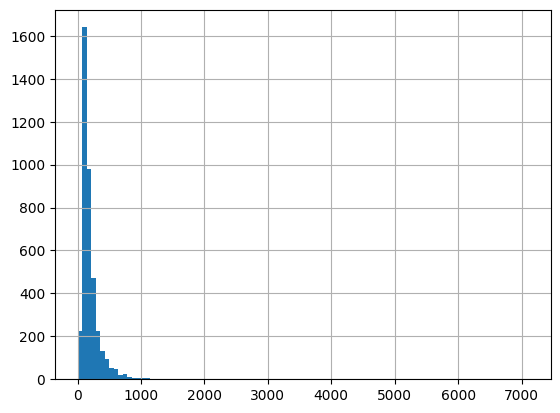

In [98]:
# average string length and distribution
pr_strings_len = pd.Series([len(el['parsed_string_llm_response_pseudoretriever']) for el in normalized_train])
pr_strings_len.hist(bins = 100)

In [91]:
pr_strings_len.describe()

,0
count,3965.000000
mean,200.530643
std,204.291440
min,0.000000
25%,105.000000
50%,148.000000
75%,229.000000
max,7109.000000


# Step 2. QA

Use model: gpt-4o-2024-08-06

Cost per 1m input tokens: $2.50

Cost per 1m output tokens: $10.00

Maxinum length of the output: 50 tokens

In [101]:
def return_full_prompt_string_qa(record):
  qa_question = record['qa']['question']
  context = record['parsed_string_llm_response_pseudoretriever']

  additional_boolean_instruction = 'If the answer to the prompt is yes, return 1. If the answer is no, return 0.'

  system_message = f"""You are a top finance expert specializing in financial and economic calculations.
  Provide an answer to the prompt using examples as your guidance.
  If you cannot find anything at all in context to answer the prompt question, return 'no_support_info'.
  """


  user_message = f"""Given financial question: {qa_question} and the context: {context},
  calculate and return the answer to this question as ONE SINGLE NUMBER. While calculating an answer,
  follow the mathematical order of operations and think of step-by-step approach to solve the calculation.
  Do NOT output these intermediate calculations as the answer, return only the final result.
  Output format rules:

  1. If the answer to the prompt is a number, return just a number rounded to the .0000 (4th decimal point),
  2. No additional symbols such as % or currency symbols, and no thousands separator.
  3. If the number is a percentage, return the decimal fraction of that percentage (for example, 0.3 for 30%)
  4. If the answer to the prompt is yes, return 1. If the answer is no, return 0.


  Example input: 'Given financial question: 'What is a percentage difference between j1 and j2 performance across A, B and C'
  and the context: j1 in A: 3, j1 in B: 4, j1 in C: 5, j2 in A: 3, j2 in B: 4, j2 in C: 5,
  calculate and return the answer to this question. While calculating an answer,
  follow the mathematical order of operations and think of step-by-step approach to solve the calculation.'
  Example output: '0'
  """

  return([{"role": "system", "content": system_message}, {"role": "user", "content": user_message}])


In [102]:
input_cost_1m_qa = 2.5
output_cost_1m_qa = 10
total_n_input_tokens_qa = sum([len(encoding.encode(str(return_full_prompt_string_qa(record))))
                            for record in normalized_train])
print(total_n_input_tokens_qa)
input_cost_qa = (total_n_input_tokens_qa / 1000000) * input_cost_1m_qa
print(input_cost_qa)

output_cost = output_cost_1m * ((len(normalized_train) * 50)/1000000)
print(output_cost)
# the main extraction costs about $4.50

1909383
4.7734575
0.01486875


In [104]:
sample_prompt_qa = return_full_prompt_string_qa(normalized_train[-1])


In [106]:
sample_prompt_qa

[{'role': 'system',
  'content': "You are a top finance expert specializing in financial and economic calculations. \n  Provide an answer to the prompt using examples as your guidance.\n  If you cannot find anything at all in context to answer the prompt question, return 'no_support_info'. \n  "},
 {'role': 'user',
  'content': "Given financial question: what was the average capital expenditures , in millions , for 2016 and 2015? and the context: capital expenditures for 2016: $64 million, capital expenditures for 2015: $90 million, \n  calculate and return the answer to this question as ONE SINGLE NUMBER. While calculating an answer, \n  follow the mathematical order of operations and think of step-by-step approach to solve the calculation. \n  Do NOT output these intermediate calculations as the answer, return only the final result.\n  Output format rules:\n\n  1. If the answer to the prompt is a number, return just a number rounded to the .0000 (4th decimal point),\n  2. No addition

In [107]:
sample_response_qa = client.chat.completions.create(
    model="gpt-4o-2024-08-06",
    messages=sample_prompt_qa,
    max_tokens=2000,
    # we need the least amount of imagination from llm
    temperature=0.0,
)

In [122]:
# run the main extraction and put the raw responses into the model
i = 0
for record in normalized_train:
  if i % 100 == 0:
    print (i)
  if isinstance(record['qa_ans'], float):
    i += 1
    continue

  prompt = return_full_prompt_string_qa(record)

  response = client.chat.completions.create(
    model="gpt-4o-2024-08-06",
    messages=prompt,
    max_tokens=50,
    temperature=0.0,
  )
  parsed_response  = response.choices[0].message.content
  record['full_llm_response_qa'] = response
  record['parsed_string_llm_response_qa'] = parsed_response

  # little timeout not to stress him too much
  sleep(0.1)
  i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [ ]:
import re
# postprocessing the number

def postprocess_number(text_number):
  # return none if no answer is provided
  if text_number == 'no_support_info':
    return(None)

  match = re.search(r"[-+]?\d*\.\d+([eE][-+]?\d+)?", text_number)

  if match:
    float_value = float(match.group())
    return(float_value)
  else:
    print(text_number)
    return(None)

In [123]:
for record in normalized_train:
  record['qa_ans'] = postprocess_number(record['parsed_string_llm_response_qa'])

To find the portion of the total shares subject to outstanding awards that is under the 2009 global incentive plan, we need to calculate the ratio of the 2009 plan shares subject to outstanding awards to the total shares subject to outstanding awards from both
0
To solve the problem, we need to determine the percentage that the 2005 charge for asset impairments represents of the pre-impairment earnings for the optical and specialty materials segment.

1. **Determine the pre-impairment earnings for
To find the number of common stock shares for which the company paid dividends in 2012, we need to use the information provided about the dividends declared and the dividend per share amounts.

1. The total dividends declared during fiscal 2012 amounted to
To find the implied composite debt level for 2014, we can use the formula for interest expense:

Interest Expense = Debt Level * Interest Rate

Given:
- Interest Expense for 2014 = 561 million
- Interest Rate = 7
242518
To find out how many

In [125]:
# % Nones - just 5% which is okay for a POC

len([el['qa_ans'] for el in normalized_train if el['qa_ans'] is None]) / len(normalized_train)

0.05044136191677175

In [126]:
pd.Series([el['qa_ans'] for el in normalized_train]).describe()

,0
count,3.765000e+03
mean,1.391985e+08
std,6.137423e+09
min,-6.140000e+07
25%,5.560000e-02
50%,3.660000e-01
75%,4.598500e+00
max,3.596000e+11


# Step 3. Evaluation


In [132]:
normalized_train[-1]['qa']

{'question': 'what was the average capital expenditures , in millions , for 2016 and 2015?',
 'answer': '77',
 'explanation': '',
 'ann_table_rows': [],
 'ann_text_rows': [21],
 'steps': [{'op': 'add2-1', 'arg1': '90', 'arg2': '64', 'res': '154'},
  {'op': 'divide2-2', 'arg1': '#0', 'arg2': 'const_2', 'res': '77'}],
 'program': 'add(90, 64), divide(#0, const_2)',
 'gold_inds': {'text_21': 'additionally , capital expenditures decreased $ 26 million to $ 64 million from $ 90 million for 2016 and 2015 , respectively , primarily due to spending for our new office location in 2015 .'},
 'exe_ans': 77.0,
 'program_re': 'divide(add(90, 64), const_2)',
 'exe_ans_float': 77.0,
 'exe_ans_type': 'float'}

In [146]:
for record in normalized_train:
  # if the record is None, the difference is 100%
  if record['qa_ans'] is None:
    record['pct_difference_qa_answer'] = 1
  else:
    if record['qa']['exe_ans_float'] == 0:
      if record['qa_ans'] != 0:
        record['pct_difference_qa_answer'] = 1
      else:
        record['pct_difference_qa_answer'] = 0
    else:


        record['pct_difference_qa_answer'] = abs(record['qa_ans'] - record['qa']['exe_ans_float'])/record['qa']['exe_ans_float']

  if record['pct_difference_qa_answer'] > 0.01:
    record['bool_success_99'] = False
  else:
    record['bool_success_99'] = True
  if record['pct_difference_qa_answer'] > 0.05:
    record['bool_success_95'] = False
  else:
    record['bool_success_95'] = True


In [147]:
# evaluate

eval_pct_diff = pd.Series([el['pct_difference_qa_answer'] for el in normalized_train])
pct_successful_99 = pd.Series([el['bool_success_99'] for el in normalized_train])
pct_successful_95= pd.Series([el['bool_success_95'] for el in normalized_train])

In [148]:
eval_pct_diff.describe()

,0
count,3.965000e+03
mean,2.636257e+06
std,7.473134e+07
min,-2.158013e+04
25%,0.000000e+00
50%,2.716653e-04
75%,4.477523e-01
max,3.500209e+09


In [150]:
pct_successful_99.value_counts()

,count
True,2739
False,1226


In [151]:
# success rate out of total at 99%

2739/(2739 + 1226)

0.6907944514501891

In [152]:

pct_successful_95.value_counts()


,count
True,2806
False,1159


In [153]:
2806/(2806 + 1159)

0.7076923076923077